(256, 256) (256, 256)


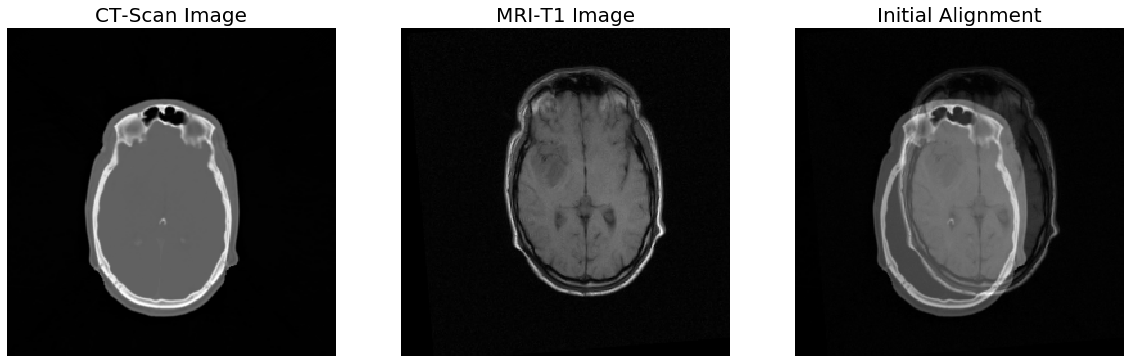

In [1]:
%matplotlib inline
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

fixed_image =  sitk.ReadImage("images/ct_scan_11.jpg", sitk.sitkFloat32)
moving_image = sitk.ReadImage("images/mr_T1_06.jpg", sitk.sitkFloat32) 

fixed_image_array = sitk.GetArrayFromImage(fixed_image)
moving_image_array = sitk.GetArrayFromImage(moving_image)
print(fixed_image_array.shape, moving_image_array.shape)
plt.figure(figsize=(20,10))
plt.gray()
plt.subplot(131), plt.imshow(fixed_image_array), plt.axis('off'), plt.title('CT-Scan Image', size=20)
plt.subplot(132), plt.imshow(moving_image_array), plt.axis('off'), plt.title('MRI-T1 Image', size=20)
plt.subplot(133), plt.imshow(0.6*fixed_image_array + 0.4*moving_image_array), plt.axis('off'), plt.title('Initial Alignment', size=20)
plt.show()

In [3]:
np.random.seed(2)
registration_method = sitk.ImageRegistrationMethod()

initial_transform = sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.Similarity2DTransform())
   
# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32),sitk.Cast(moving_image, sitk.sitkFloat32))


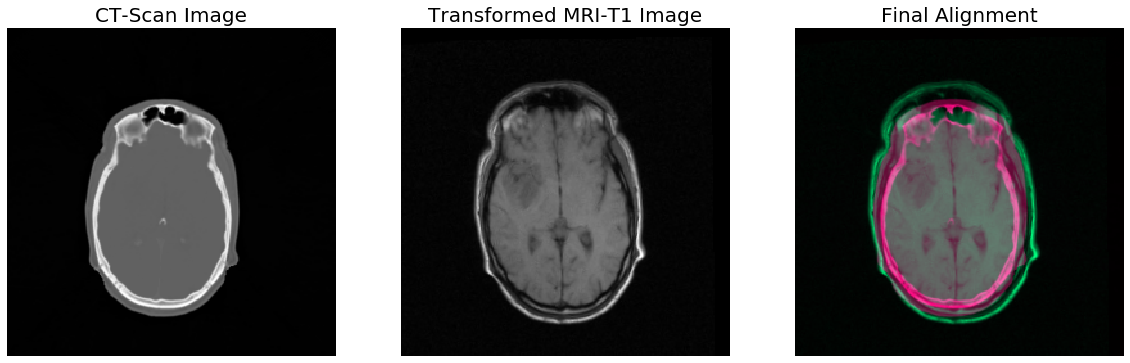

In [4]:
#print(final_transform)
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed_image);
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(100)
resampler.SetTransform(final_transform)
 
out = resampler.Execute(moving_image)
simg1 = sitk.Cast(sitk.RescaleIntensity(fixed_image), sitk.sitkUInt8)
simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
cimg = sitk.Compose(simg1, simg2, simg1//2.+simg2//2.)

plt.figure(figsize=(20,10))
plt.gray()
plt.subplot(131), plt.imshow(fixed_image_array), plt.axis('off'), plt.title('CT-Scan Image', size=20)
plt.subplot(132), plt.imshow(sitk.GetArrayFromImage(out)), plt.axis('off'), plt.title('Transformed MRI-T1 Image', size=20)
plt.subplot(133), plt.imshow(sitk.GetArrayFromImage(cimg)), plt.axis('off'), plt.title('Final Alignment', size=20)
plt.show()